Выберем парметры ижикевича, при которых возникает пачечная активность без автоколебаний

[0.01] [0.26] [-50] [2]


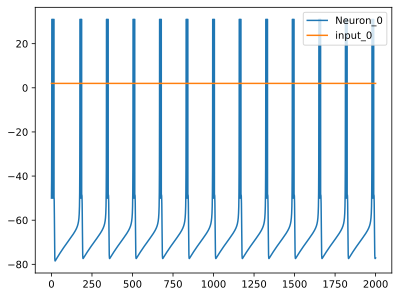

In [63]:
from Izh_net import *
from net_preparation import *
from matplotlib import pyplot as plt
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']
np.random.seed(200)
def run_net(T, net, I_app):
    """
    Procedure of running network 
    args:
    T - discrete time array
    net - network object
    I_app - applied current
    I_aff - afferents activity
    retrun U, V - state of network array with shape(len(T), N), 
    N - size of
    """
    net.set_init_conditions()
    dt = T[1] - T[0]
    N = len(net)
    U = np.zeros((len(T), N))
    V = np.zeros((len(T), N))
    for i, t in enumerate(T):
        U[i] = net.U_prev
        V[i] = net.V_prev
        net.step(dt=dt, Iapp = I_app[i])
    return U, V
    
N = 1#size of network
A = np.array([0.01])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
print(A, B, C, D)
net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)

sample_rate = 5
T_max = 2000
T = np.linspace(0, T_max , T_max*sample_rate)
I = np.zeros(N)
I[0] = 2
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=1)
I_aff = lambda t: 0
U, V = run_net(T, net, input) 
for i in range(N):
    plt.plot(T, V[:, i], label=f"{net.names[i]}")
    plt.plot(T, input, label=f'input_{i}')
plt.legend()
plt.show()

Во всех дальнейших опытах завиксируем 
- b = 0.26
- d = 2
- I = 2
- T = 5сек

Проведем анализ частоты пачек в зависимости от параметра a

c = -50 mV

Для локализации пачек используем следующий алгоритм:
1) рассмотрим общее чисто импульсов нейрона fire_t
2) расчитаем интенсивность спайков на всем времени симуляции: $fc = len(fire_t)/T_{max}$
3) Рассчитаем пороговое время для малого пачечного события
   $\tau_c = min(2/(fc), 100)$
4) Проходясь по всем временям спайков будем добавлять в пачку те, расстояния между которыми меньше $\tau_c$

In [3]:
from net_preparation import *

net = Izhikevich_Network(N=1)
A = np.array([0.002])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])

    
    
def draw_bursts(brusts, v):
    for x in brusts:
        plt.axvline(x = min(x), ymin=0, ymax=1, color='red', linewidth=1)
        plt.axvline(x = max(x), ymin=0, ymax=1, color='blue', linewidth=1)
    return None
                   
net.set_params(a=A, b=B, c=C, d=D)
sample_rate = 10
T_max = 7000
I = np.zeros(N)
I[0] = 0
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 1*np.random.normal(size=(T_max*sample_rate), scale=3)
A_vals = np.linspace(0.001, 0.02, 200)
Distance = np.zeros((len(A_vals), 2))
with tqdm(total=len(A_vals)) as pbar:
    for i, a in enumerate(A_vals):
        net.set_params(a = np.array([a]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        begin = np.diff(bursts1[:, 0])
        end = np.diff(bursts1[:, 1])
        Distance[i, 0] = 0.5*(np.mean(begin) + np.mean(end))
        Distance[i, 1] = (np.std(begin) + np.std(end))
        # Update the progress bar
        pbar.update(1)
#np.save('burst_distance_noise.npy', Distance)

100%|██████████| 200/200 [11:34<00:00,  3.47s/it]


Получили экспоненциальное убывание расстояния между пачками при увеличении параметра а.

$$ distance \approx \frac{1}{-12.4a^2 + 0.8a + 5.5}$$




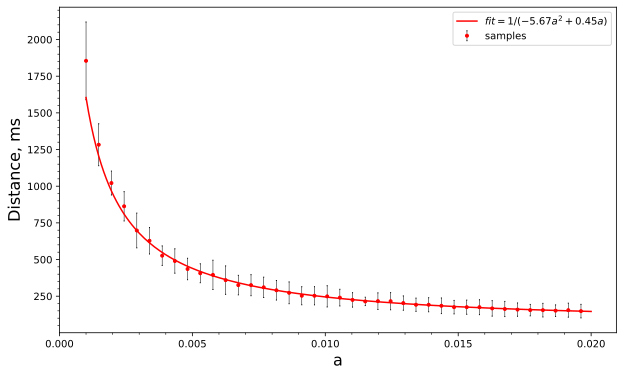

In [8]:
#A_vals = np.linspace(0.001, 0.02, 200)
#Distance_noise = np.load('burst_distance_noise.npy')
#Distance = np.load('burst_distance.npy')
model = np.polyfit(A_vals, 1/Distance[:, 0], 2)
#model_noise = np.polyfit(A_vals, 1/Distance[:, 1], 2)

fit = 1/(np.polyval(model, A_vals))
fit_noise = 1/(np.polyval(model_noise, A_vals))

plt.figure(figsize=(10, 6))
#plt.errorbar(A_vals[::5], Distance_noise[::5, 0], yerr=Distance_noise[::5, 1], fmt='.', c='b',
#             capsize=0.5, label='samples+noise', ecolor='k', elinewidth=0.5)
plt.errorbar(A_vals[::5], Distance[::5, 0], yerr=Distance[::5, 1], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)
plt.plot(A_vals, fit, color='r', label=rf"$fit = 1/({model[0].round(2)}a^2 + {model[1].round(2)}a)$")
#plt.plot(A_vals, fit_noise, color='b', label=rf"$fit = 1/({model_noise[0].round(2)}a^2 + {model_noise[1].round(2)}a)$")


#plt.plot(A_vals, fit, label='fit', linestyle='--', color='k', linewidth=3)
plt.ylabel('Distance, ms', fontsize=16)
plt.xticks(np.linspace(0, 0.02, 5))
plt.minorticks_on()
plt.xlabel('a', fontsize=16)
plt.legend()
#plt.savefig('burst_distance_compare.eps', format='eps')
#plt.show()

Рассчитаем зависимость длинны пачки от праметра $c$ - потенциал сброса

In [10]:
sample_rate = 5
T_max = 7000
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
A = np.array([0.02])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net.set_params(a=A, b=B, c=C, d=D)

C_vals = np.linspace(-50, -35, 200)
# mean and std of differences between beginings of bursts

duration = np.zeros((len(C_vals), 2))
with tqdm(total=len(A_vals)) as pbar:
    for i, c in enumerate(C_vals):
        net.set_params(c = np.array([c]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
        duration[i, 0] = dur
        std = np.std(bursts1[:, 1] - bursts1[:, 0])
        duration[i, 1] = std
        pbar.update(1)

100%|██████████| 200/200 [05:55<00:00,  1.78s/it]


При изменении параметра длинна пачки изменялась по закону:
$$
Duration = 0.8\cdot c + 46.7
$$

Рассчитаем зависимость длинны пачки от праметра $d$ - потенциал сброса

In [ ]:
sample_rate = 5
T_max = 7000
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
A = np.array([0.02])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net.set_params(a=A, b=B, c=C, d=D)

D_vals = np.linspace(0.05, 8, 20)
# mean and std of differences between beginings of bursts

duration = np.zeros((len(D_vals), 2))
with tqdm(total=len(D_vals)) as pbar:
    for i, c in enumerate(D_vals):
        net.set_params(c = np.array([c]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
        duration[i, 0] = dur
        std = np.std(bursts1[:, 1] - bursts1[:, 0])
        duration[i, 1] = std
        pbar.update(1)

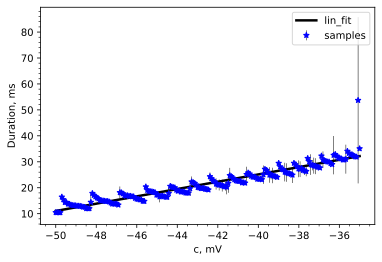

[ 1.40909314 81.49569715]


In [11]:
#np.save('bursts/durations200.npy', duration)
model = np.polyfit(C_vals, duration[:, 0], 1)
plt.errorbar(C_vals, duration[:, 0], yerr=duration[:, 1], fmt='*', c='b', label='samples', ecolor='k', elinewidth=0.5)
plt.plot(C_vals, np.polyval(model, C_vals), color='black', linewidth=2.5, label='lin_fit')
plt.xlabel('c, mV')
plt.minorticks_on()
plt.ylabel('Duration, ms')
plt.legend()
#plt.savefig('bursts/Duration200(c).eps', format='eps')
plt.show()
print(model)


При изменении этих параметров попбробуем пустить нормально распределенный шум на нейроны с такими параметрами


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


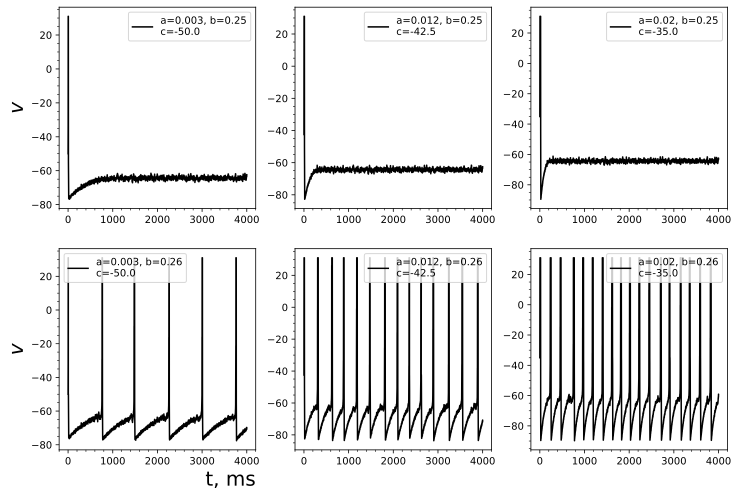

In [157]:
sample_rate = 50
T_max = 4000
I = np.zeros(N)
I[0] = 0
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 1*np.random.normal(size=(T_max*sample_rate), scale=3)#*(T>1000)
num_samples = 3
A_vals = np.linspace(0.003, 0.02, num_samples)
C_vals = np.linspace(-50, -35, num_samples)
B_vals = np.array([0.25, 0.26])
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for k in range(2):
    for i in range(num_samples):
        net.set_params(a = np.array([A_vals[i]]),
                       c = np.array([C_vals[i]]),
                       b = np.array([B_vals[k]]))
        U, V = run_net(T, net, input) 
        #firings_t, _ = create_firing_rastr(V, T, 30)
        #bursts = find_bursts(firings_t, T_max)
        #bursts1 = get_bursts_regions(bursts)
        #begin = np.diff(bursts1[:, 0])
        #end = np.diff(bursts1[:, 1])
        #Begin_stat[i] = np.mean(begin)
        #End_stat[i] = np.mean(end)
        #ax[k, i].set_title(f'a={a.round(3)}, c={c.round(3)}')
        ax[k, i].plot(T, V, 'k', label=f'a={A_vals[i].round(3)}, b={B_vals[k].round(3)}\nc={C_vals[i].round(3)}')
        #ax1 = ax.twinx()
        #ax1.plot(T, input, 'g')
        #ax1.set_ylabel(r"$I_{app}$")
        if i%3==0:
            ax[k, i].set_ylabel(r'$v$', fontsize=20)
            if k==1:
                ax[k, i].set_xlabel('t, ms', loc='right', fontsize=20)
        ax[k, i].minorticks_on()
        ax[k, i].legend(fontsize=10, loc=0)
        #draw_bursts(bursts, V, T)
plt.savefig(f'busrt_noise.eps', format='eps')
plt.show()
        

exp_long_time - симуляции 20000 ms ts=50p/ms шум с дисперсией 4